# Merging MERRA-2 Datasets

In [121]:
import xarray as xr
import numpy as np
from pathlib import Path

# Test out Compression Schemes

1. Preprocessing options - prepare permutations in python
    1. data as-is
    1. reduce via binary rounding
    1. reduce via roundtrip fp16 conversion (where appropriate)
1. Compression options - run permutations in database
    1. (double)delta + LZ4
    1. (delta) + gorilla
    
This gives 6 combinations.

Rather than test the whole dataset, **I'll just pick out the corner points as a dubiously-representative sample**

In [2]:
data_dir = Path('/mnt/c/data/merra_texas/')
data_dir.exists()

True

In [91]:
filter_ = 'MERRA2_400.tavg1*.nc4.nc4' # exclude instantaneous data

In [505]:
files = data_dir.glob(filter_)
ds = xr.open_mfdataset(files, combine="by_coords",
                       concat_dim="time",
                       data_vars='minimal',
                       coords='minimal',
                       compat='no_conflicts',
                      )#.chunk(chunks={'lat': 12, 'lon': 12, 'time': None})

In [506]:
ds = ds.isel(lat=[0, -1], lon=[0, -1]).chunk(chunks={'lat': None, 'lon': None, 'time': None})

In [507]:
ds

<xarray.Dataset>
Dimensions:      (lat: 2, lon: 2, time: 8760)
Coordinates:
  * lat          (lat) float64 26.0 37.0
  * lon          (lon) float64 -106.9 -93.12
  * time         (time) datetime64[ns] 2018-01-01T00:30:00 ... 2018-12-31T23:30:00
Data variables:
    GHLAND       (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    RHOA         (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    PRECTOTCORR  (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    Z0M          (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    RISFC        (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    PS           (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    V50M         (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    TS           (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    T10M         (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    U50M         (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
Attributes:
    History:                           Original file generated: Wed Jan 17 06...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Filename:                          MERRA2_400.tavg1_2d_flx_Nx.20180101.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    Format:                            NetCDF-4/HDF-5
    SpatialCoverage:                   global
    VersionID:                         5.12.4
    TemporalRange:                     1980-01-01 -> 2016-12-31
    identifier_product_doi_authority:  http://dx.doi.org/
    ShortName:                         M2T1NXFLX
    GranuleID:                         MERRA2_400.tavg1_2d_flx_Nx.20180101.nc4
    ProductionDateTime:                Original file generated: Wed Jan 17 06...
    LongName:                          MERRA2 tavg1_2d_flx_Nx: 2d,1-Hourly,Ti...
    Title:                             MERRA2 tavg1_2d_flx_Nx: 2d,1-Hourly,Ti...
    SouthernmostLatitude:              -90.0
    NorthernmostLatitude:              90.0
    WesternmostLongitude:              -180.0
    EasternmostLongitude:              179.375
    LatitudeResolution:                0.5
    LongitudeResolution:               0.625
    DataResolution:                    0.5 x 0.625
    Source:                            CVS tag: GEOSadas-5_12_4_p13_M2-OPS
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/7MCPBJ41Y0K6
    RangeBeginningDate:                2018-01-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2018-01-01
    RangeEndingTime:                   23:59:59.000000
    DODS_EXTRA.Unlimited_Dimension:    time
    history:                           2020-05-18 12:19:39 GMT Hyrax-1.15.1 h...

## Compression Pre-processing
Basic premise is to remove false precision by binary rounding or casting to fp16 and back (forms of quantization)
1. binary rounding creates a fixed chunk of leading 0s, at the cost of lost precision for small numbers
1. f32->f16->f32 creates fixed precision at the cost of reduced compressibility (I think - will try it out). Also not appropriate if actual precision exceeds 3.3 decimal digits (limit of fp16)

Column-specific adjustments:
* convert velocity components to magnitude/direction. Just for convenience
* log transform PRECTOTCORR due to huge magnitude range (1e-2 to 1e-18 to 0)
* Cast PS to int instead of leaving 6+ digits of false precision. Don't worry about changing units to get into int16 range - delta encoding will take care of that.
* convert temperature units from K to C

Notes:
* any run-length encoding will squish lat/lon to nothing
* double vs single delta on time - seen from benchmarks that it makes a tiny difference. Difference between 99.6 and 99.9%

"reduce" in the following table refers to the option between the two precison reduction functions. Some columns can't use fp16 conversion because I want more digits, so they explicitly say "binary round"

| Column | Sig Figs | Decimals | Preprocess | Compression |
| :-- | :-: | :-: | :-- | :-- |
| lat/lon |  |  |  | delta or low_cardinality, +LZ4 |
| time |  |  |  | (double)delta + LZ4 |
| GHLAND | 3 | 0.5 | reduce | either (delta + LZ4) or gorilla |
| RHOA | 4 | 3 | reduce |  |
| PRECTOTCORR | 3 | 7 | add 5e-15, log10, reduce | gorilla |
| Z0M |  |  | This column looks useless. Drop it |  |
| RISFC | ? | 1 | reduce | delta |
| PS | 4 | -1 | div 10, round, mul 10, fp32->int32 | doubledelta + LZ4|
| TS, deg C | 3 | 1 | sub 273.15, reduce | doubledelta |
| T10M, deg C | 3 | 1 | sub 273.15, reduce |  doubledelta |
| speed | 4 | 3 | binary round | doubledelta |
| direction | 4 | 1 | binary round | doubledelta |

In [508]:
from typing import Optional, Union
def binary_round(ds: Union[xr.Dataset, xr.DataArray, np.ndarray], *, binary_bits: Optional[int]=None, decimal_digits: Optional[int]=None):
    """Convert floating point to fixed point by rounding an array of floats to a specific number of bits.
    Motivation is to enable higher compression by chopping off false precision in simulation and measurement data.
    """
    if binary_bits:
        bits = binary_bits
        if decimal_digits:
            raise ValueError(f"Only one of binary_bits and decimal_digits can be used. Given {binary_bits} and {decimal_digits}, respectively.")
    elif decimal_digits:
        bits = np.ceil(decimal_digits * np.log(10) / np.log(2))
    else:
        raise ValueError(f"One of binary_bits and decimal_digits must be an integer. Given {binary_bits} and {decimal_digits}, respectively.")
    
    multiplier = 2**bits
    divisor = 2**(-1*bits) # faster multiply by reciprocal than to divide, according to some StackOverflow post. Probably doesn't matter much.
    return (ds * multiplier).round() * divisor

In [509]:
np.array([1.1, 1.2, 1.3]) + 2**-22 # add tiny offset to make python print extra digits

array([1.10000024, 1.20000024, 1.30000024])

In [510]:
np.array([1.1, 1.2, 1.3]).astype(np.float16).astype(np.float32)

array([1.0996094, 1.2001953, 1.2998047], dtype=float32)

In [511]:
binary_round(np.array([1.1, 1.2, 1.3]), decimal_digits=3)

array([1.09960938, 1.20019531, 1.29980469])

In [512]:
# interestingly it also works for negative values - instead of rounding to nearest 10, it rounds to nearest 8 (closest in binary)
binary_round(np.array(range(99,111)), decimal_digits=-1)

array([ 96.,  96., 104., 104., 104., 104., 104., 104., 104., 112., 112.,
       112.])

In [513]:
def chunk_transformations(ds: xr.Dataset):
    ds.update(ds[['TS', 'T10M']] - 273.15) # convert units K -> C
    ds['WS50M'] = np.sqrt(np.square(ds['V50M']) + np.square(ds['U50M']))
    ds['WDIR50M'] = np.mod(np.arctan2(ds['U50M'], ds['V50M']) + 2*np.pi, 2*np.pi) * (180/np.pi)  # This gives angle off North, see below tests
    ds['PRECTOTCORR'] = np.log10(ds['PRECTOTCORR'] + 2**-48)
    return ds.drop_vars(['U50M', 'V50M', 'Z0M'])

In [514]:
def reduce_precision(ds, fp16=False):
    ds[['lat', 'lon']].astype(np.float32)
    ds['PS'] = binary_round(ds['PS'], decimal_digits=-1).astype(np.int32)
    mask = ds['PRECTOTCORR'] <= -14 # assumes log10 applied first!
    ds['PRECTOTCORR'] = xr.where(mask, 0, ds['PRECTOTCORR']) # threshold tiny floats to 0
    if fp16:
        f16 = ['GHLAND', 'RHOA', 'PRECTOTCORR', 'RISFC', 'TS', 'T10M']
        ds.update(ds[f16].astype(np.float16).astype(np.float32))
        for dec, cols in {1: ['WDIR50M'], 3: ['WS50M']}:
            ds.update(binary_round(ds[cols], decimal_digits=dec))
    else:
        prec = {1: ['GHLAND', 'RISFC', 'TS', 'T10M', 'WDIR50M'], 2: ['PRECTOTCORR'], 3: ['RHOA', 'WS50M']}
        for dec, cols in prec.items():
                ds.update(binary_round(ds[cols], decimal_digits=dec))

In [515]:
ds = chunk_transformations(ds)
ds

<xarray.Dataset>
Dimensions:      (lat: 2, lon: 2, time: 8760)
Coordinates:
  * lat          (lat) float64 26.0 37.0
  * lon          (lon) float64 -106.9 -93.12
  * time         (time) datetime64[ns] 2018-01-01T00:30:00 ... 2018-12-31T23:30:00
Data variables:
    GHLAND       (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    RHOA         (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    PRECTOTCORR  (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    RISFC        (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    PS           (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    TS           (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    T10M         (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    WS50M        (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    WDIR50M      (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
Attributes:
    History:                           Original file generated: Wed Jan 17 06...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Filename:                          MERRA2_400.tavg1_2d_flx_Nx.20180101.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    Format:                            NetCDF-4/HDF-5
    SpatialCoverage:                   global
    VersionID:                         5.12.4
    TemporalRange:                     1980-01-01 -> 2016-12-31
    identifier_product_doi_authority:  http://dx.doi.org/
    ShortName:                         M2T1NXFLX
    GranuleID:                         MERRA2_400.tavg1_2d_flx_Nx.20180101.nc4
    ProductionDateTime:                Original file generated: Wed Jan 17 06...
    LongName:                          MERRA2 tavg1_2d_flx_Nx: 2d,1-Hourly,Ti...
    Title:                             MERRA2 tavg1_2d_flx_Nx: 2d,1-Hourly,Ti...
    SouthernmostLatitude:              -90.0
    NorthernmostLatitude:              90.0
    WesternmostLongitude:              -180.0
    EasternmostLongitude:              179.375
    LatitudeResolution:                0.5
    LongitudeResolution:               0.625
    DataResolution:                    0.5 x 0.625
    Source:                            CVS tag: GEOSadas-5_12_4_p13_M2-OPS
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/7MCPBJ41Y0K6
    RangeBeginningDate:                2018-01-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2018-01-01
    RangeEndingTime:                   23:59:59.000000
    DODS_EXTRA.Unlimited_Dimension:    time
    history:                           2020-05-18 12:19:39 GMT Hyrax-1.15.1 h...

In [516]:
reduce_precision(ds)
ds

<xarray.Dataset>
Dimensions:      (lat: 2, lon: 2, time: 8760)
Coordinates:
  * lat          (lat) float64 26.0 37.0
  * lon          (lon) float64 -106.9 -93.12
  * time         (time) datetime64[ns] 2018-01-01T00:30:00 ... 2018-12-31T23:30:00
Data variables:
    GHLAND       (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    RHOA         (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    PRECTOTCORR  (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    RISFC        (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    PS           (time, lat, lon) int32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    TS           (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    T10M         (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    WS50M        (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
    WDIR50M      (time, lat, lon) float32 dask.array<chunksize=(8760, 2, 2), meta=np.ndarray>
Attributes:
    History:                           Original file generated: Wed Jan 17 06...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Filename:                          MERRA2_400.tavg1_2d_flx_Nx.20180101.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    Format:                            NetCDF-4/HDF-5
    SpatialCoverage:                   global
    VersionID:                         5.12.4
    TemporalRange:                     1980-01-01 -> 2016-12-31
    identifier_product_doi_authority:  http://dx.doi.org/
    ShortName:                         M2T1NXFLX
    GranuleID:                         MERRA2_400.tavg1_2d_flx_Nx.20180101.nc4
    ProductionDateTime:                Original file generated: Wed Jan 17 06...
    LongName:                          MERRA2 tavg1_2d_flx_Nx: 2d,1-Hourly,Ti...
    Title:                             MERRA2 tavg1_2d_flx_Nx: 2d,1-Hourly,Ti...
    SouthernmostLatitude:              -90.0
    NorthernmostLatitude:              90.0
    WesternmostLongitude:              -180.0
    EasternmostLongitude:              179.375
    LatitudeResolution:                0.5
    LongitudeResolution:               0.625
    DataResolution:                    0.5 x 0.625
    Source:                            CVS tag: GEOSadas-5_12_4_p13_M2-OPS
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/7MCPBJ41Y0K6
    RangeBeginningDate:                2018-01-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2018-01-01
    RangeEndingTime:                   23:59:59.000000
    DODS_EXTRA.Unlimited_Dimension:    time
    history:                           2020-05-18 12:19:39 GMT Hyrax-1.15.1 h...

In [517]:
ds.time.size

8760

In [518]:
ds['TS'].size * 4 / 10**3

140.16

In [522]:
dsk = ds.to_dask_dataframe().persist()

In [523]:
dsk.columns

Index(['lat', 'lon', 'time', 'GHLAND', 'RHOA', 'PRECTOTCORR', 'RISFC', 'PS',
       'TS', 'T10M', 'WS50M', 'WDIR50M'],
      dtype='object')

In [489]:
dsk.repartition(divisions=[0, 8760*2, 8760*4 -1]).to_parquet(data_dir / 'parq/', compression='snappy', write_index=False)

In [490]:
import dask

In [504]:
a = dask.dataframe.read_parquet(data_dir / 'parq/')
a.dtypes

lon                   float64
time           datetime64[ns]
GHLAND                float32
RHOA                  float32
PRECTOTCORR           float32
Z0M                   float32
RISFC                 float32
PS                      int32
TS                    float32
T10M                  float32
WS50M                 float32
WDIR50M               float32
dtype: object

In [493]:
a.divisions

(26.0, 37.0, 37.0)

In [501]:
a.dtypes

lon                   float64
time           datetime64[ns]
GHLAND                float32
RHOA                  float32
PRECTOTCORR           float32
Z0M                   float32
RISFC                 float32
PS                      int32
TS                    float32
T10M                  float32
WS50M                 float32
WDIR50M               float32
dtype: object

# Analyze to see what precision is necessary

In [316]:
test = ds.to_dask_dataframe(dim_order=None)

In [213]:
y = np.array([1,-1,-1,1])
x = np.array([1,1,-1,-1])
np.mod(np.arctan2(x,y) + 2*np.pi, 2*np.pi)

array([0.78539816, 2.35619449, 3.92699082, 5.49778714])

In [359]:
test['WS50M'] = np.sqrt(np.square(test['V50M']) + np.square(test['U50M']))
test['WDIR50M'] = np.mod(np.arctan2(test['U50M'], test['V50M']) + 2*np.pi, 2*np.pi) * (180/np.pi)  # This gives angle off North, see above cell
test = test.drop(columns=['U50M', 'V50M'])

In [221]:
test.head()

,lat,lon,time,GHLAND,RHOA,PRECTOTCORR,Z0M,RISFC,PS,TS,T10M,WS,WDIR
0,26.0,-106.875,2018-01-01 00:30:00,-64.469193,0.957152,3.403984e-07,2.075200,1.586672,78798.625000,279.817627,284.931519,2.556249,61.572544
1,26.0,-106.875,2018-01-01 01:30:00,-67.695580,0.960699,8.143252e-08,2.075200,5.576437,78846.234375,278.298096,284.406860,1.650219,34.395657
2,26.0,-106.875,2018-01-01 02:30:00,-66.389740,0.963250,2.904017e-09,2.075200,4.416786,78875.625000,277.290894,283.755066,1.510587,336.927368
3,26.0,-106.875,2018-01-01 03:30:00,-63.822300,0.965077,5.964012e-10,2.075200,2.944792,78895.562500,276.522125,283.115204,1.953282,305.201447
4,26.0,-106.875,2018-01-01 04:30:00,-61.357075,0.966779,3.009291e-10,2.074224,2.978859,78916.382812,275.866699,282.600281,2.128048,286.354919


In [222]:
test.describe()

,lat,lon,GHLAND,RHOA,PRECTOTCORR,Z0M,RISFC,PS,TS,T10M,WS,WDIR
count,4.634040e+06,4.634040e+06,4.344960e+06,4.634040e+06,4.634040e+06,4.634040e+06,4.634040e+06,4.634040e+06,4.634040e+06,4.634040e+06,4.634040e+06,4.634040e+06
mean,3.150000e+01,-1.000000e+02,-4.620026e-02,1.112421e+00,2.534463e-05,2.424572e-01,-3.707820e-01,9.345757e+04,2.922463e+02,2.915667e+02,6.031149e+00,1.964253e+02
std,3.316625e+00,4.145781e+00,6.185672e+01,8.706214e-02,1.231162e-04,5.317878e-01,5.530176e+00,7.102652e+03,1.185498e+01,1.003002e+01,2.851826e+00,1.185798e+02
min,2.600000e+01,-1.068750e+02,-1.999789e+02,8.498039e-01,0.000000e+00,3.281304e-05,-3.402102e+02,7.119714e+04,2.442034e+02,2.534869e+02,3.371586e-03,0.000000e+00
25%,2.850000e+01,-1.037500e+02,-4.827605e+01,1.043526e+00,1.108697e-25,2.885937e-02,-2.096536e-01,8.758368e+04,2.834512e+02,2.841130e+02,3.933745e+00,8.183369e+01
50%,3.150000e+01,-1.000000e+02,-2.218440e+01,1.125007e+00,5.688889e-10,4.494213e-02,5.026340e-03,9.549326e+04,2.935949e+02,2.930761e+02,5.779420e+00,2.085616e+02
75%,3.450000e+01,-9.625000e+01,4.543720e+01,1.174667e+00,3.523193e-06,6.184887e-02,1.156235e-01,9.975556e+04,3.004480e+02,2.993683e+02,7.856574e+00,3.114094e+02
max,3.700000e+01,-9.312500e+01,2.497881e+02,1.382262e+00,1.211156e-02,2.405278e+00,2.866630e+02,1.041215e+05,3.291655e+02,3.177791e+02,2.559931e+01,3.599999e+02


In [223]:
test.head(8760).diff().describe()

,lat,lon,time,GHLAND,RHOA,PRECTOTCORR,Z0M,RISFC,PS,TS,T10M,WS,WDIR
count,8759.0,8759.0,8759,8759.000000,8759.000000,8.759000e+03,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000
mean,0.0,0.0,0 days 01:00:00,0.007581,0.000001,-3.884452e-11,0.000000,-0.000143,-0.069604,-0.000192,-0.000537,0.000059,-0.002631
std,0.0,0.0,0 days 00:00:00,22.252756,0.003305,2.900913e-05,0.000206,5.496992,33.729755,2.249287,1.342415,0.579151,72.890457
min,0.0,0.0,0 days 01:00:00,-100.555832,-0.019430,-1.338720e-03,-0.000977,-69.607681,-128.968750,-10.186737,-5.300964,-2.755078,-358.689178
25%,0.0,0.0,0 days 01:00:00,-10.249540,-0.001348,-5.478995e-11,0.000000,-0.179194,-25.214844,-0.943680,-0.680161,-0.341478,-1.658600
50%,0.0,0.0,0 days 01:00:00,0.158100,0.000541,0.000000e+00,0.000000,0.016453,0.203125,-0.376434,-0.220032,0.001621,2.943127
75%,0.0,0.0,0 days 01:00:00,4.369226,0.001880,1.794223e-11,0.000000,0.244182,27.789062,0.515015,0.471390,0.331391,10.573227
max,0.0,0.0,0 days 01:00:00,126.704926,0.013935,4.695654e-04,0.000977,63.361755,153.218750,12.350067,6.227875,3.309217,359.379944


## GHLAND

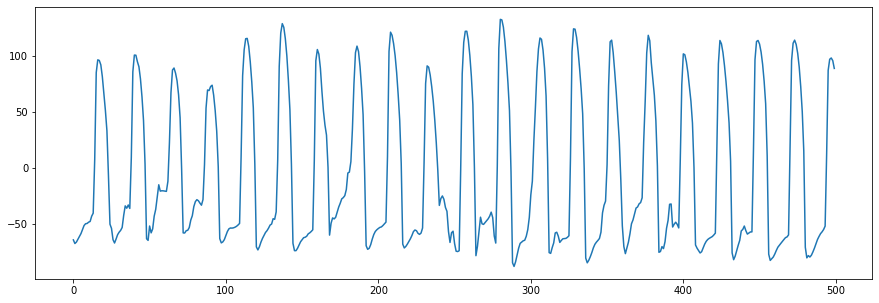

In [369]:
test['GHLAND'].head(500).plot(figsize=(15,5))

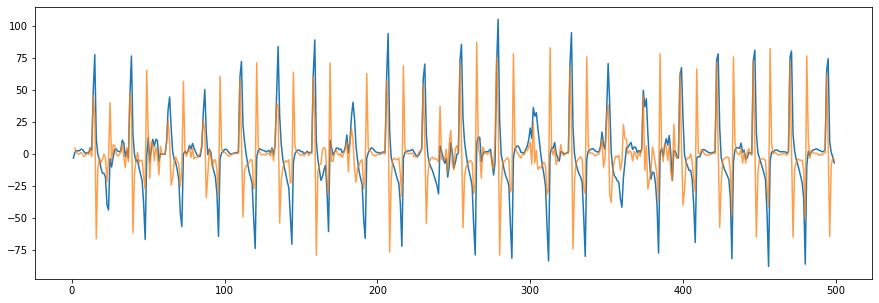

In [370]:
test['GHLAND'].head(500).diff().plot(figsize=(15,5))
test['GHLAND'].head(500).diff().diff().plot(figsize=(15,5), alpha=0.75)

## Density

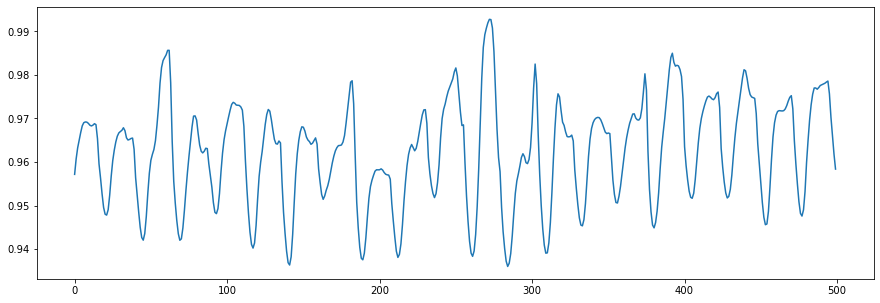

In [179]:
test['RHOA'].head(500).plot(figsize=(15,5))

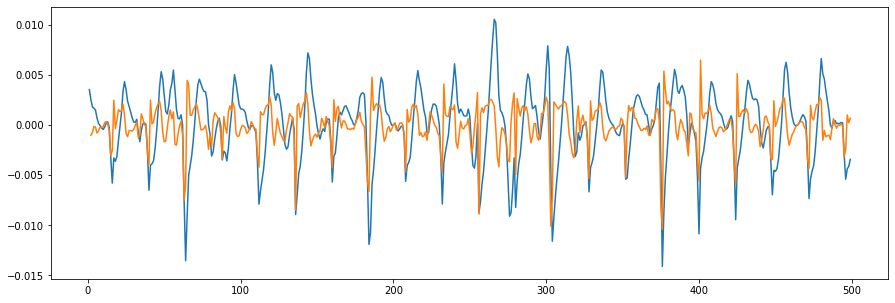

In [351]:
test['RHOA'].head(500).diff().plot(figsize=(15,5))
test['RHOA'].head(500).diff().diff().plot(figsize=(15,5))

## Roughness - over a whole year!

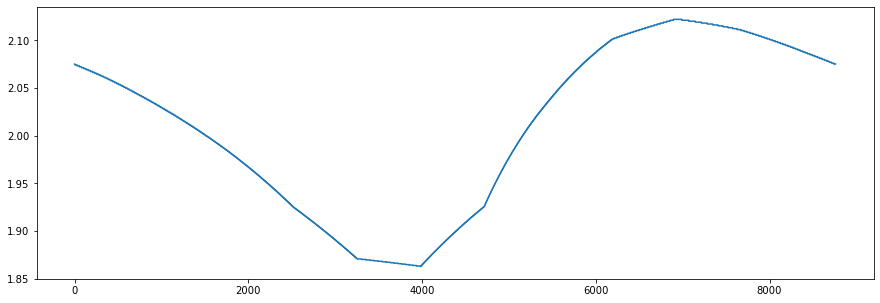

In [182]:
test['Z0M'].head(8760).dropna().plot(figsize=(15,5))

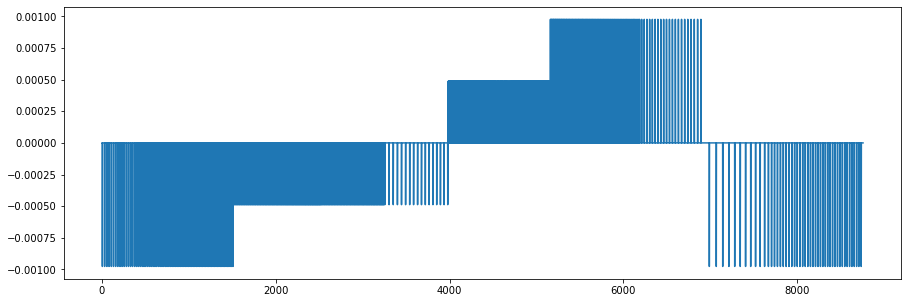

In [185]:
test['Z0M'].head(8760).diff().dropna().plot(figsize=(15,5))

## Bulk Richardson

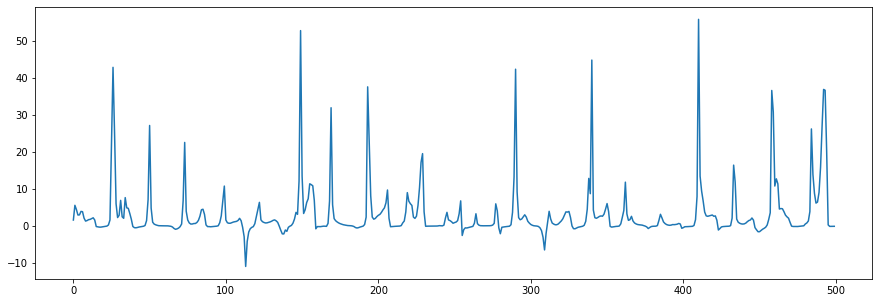

In [186]:
test['RISFC'].head(500).dropna().plot(figsize=(15,5))

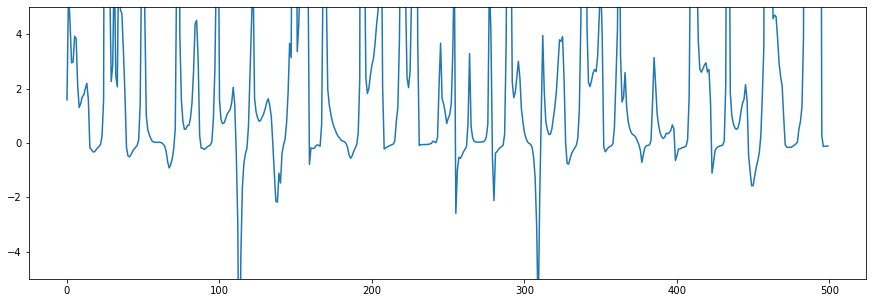

In [371]:
test['RISFC'].head(500).dropna().plot(figsize=(15,5), ylim=(-5,5))

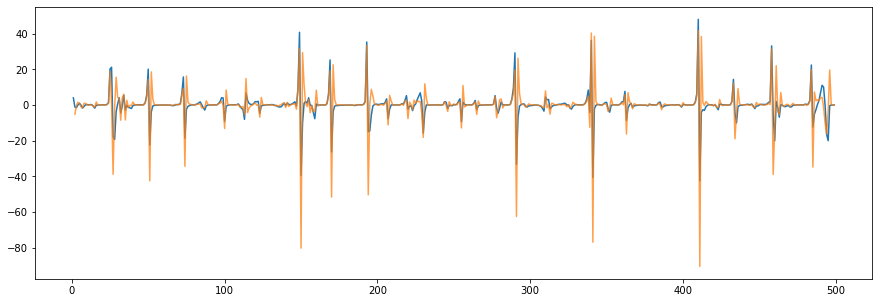

In [247]:
test['RISFC'].head(500).diff().plot(figsize=(15,5))
test['RISFC'].head(500).diff().diff().plot(figsize=(15,5), alpha=0.75)

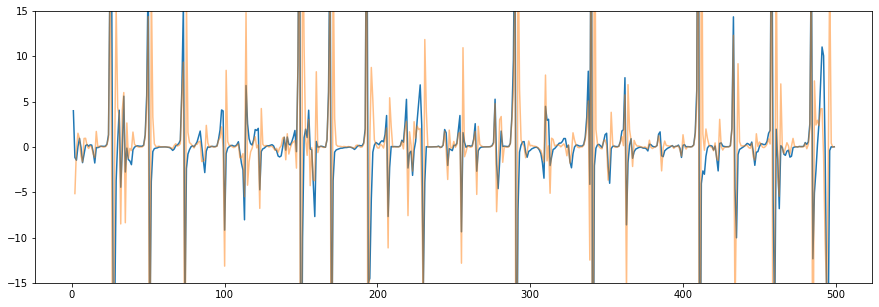

In [245]:
test['RISFC'].head(500).diff().plot(figsize=(15,5), ylim=(-15,15))
test['RISFC'].head(500).diff().diff().plot(figsize=(15,5), ylim=(-15,15), alpha=0.5)

## Pressure

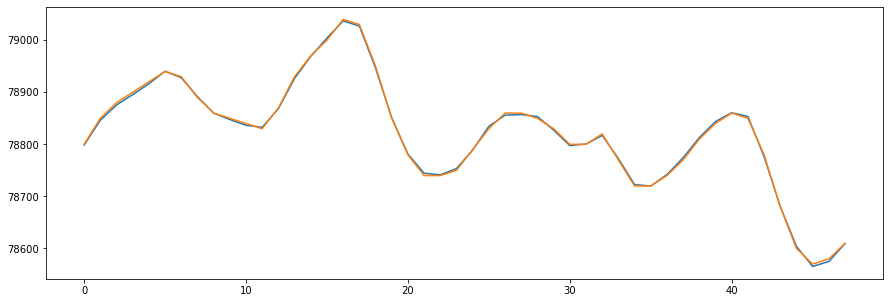

In [366]:
test['PS'].head(48).plot(figsize=(15,5))
test['PS'].head(48).div(10).round().mul(10).plot(figsize=(15,5))

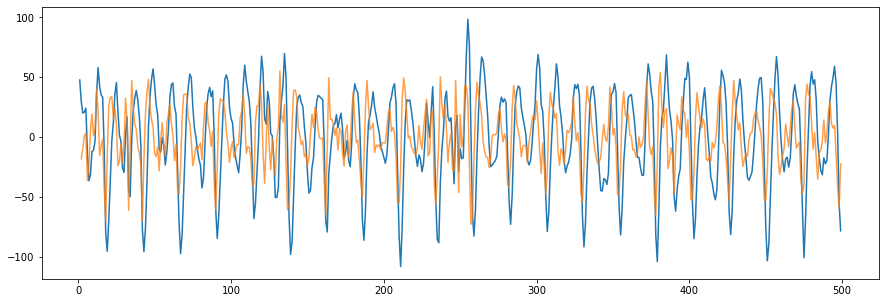

In [364]:
test['PS'].head(500).diff().plot(figsize=(15,5))
test['PS'].head(500).diff().diff().plot(figsize=(15,5), alpha=0.75)

## Temp

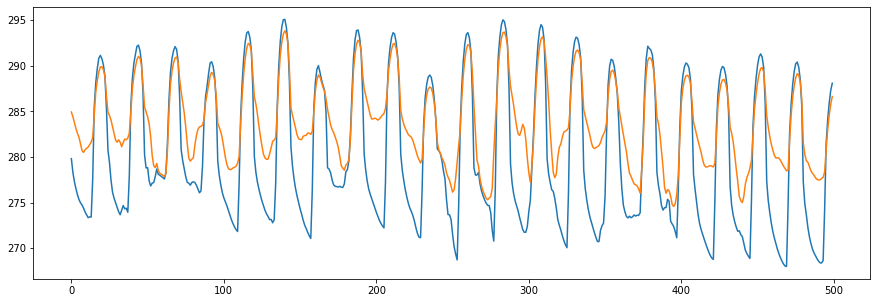

In [192]:
test['TS'].head(500).dropna().plot(figsize=(15,5))
test['T10M'].head(500).dropna().plot(figsize=(15,5))

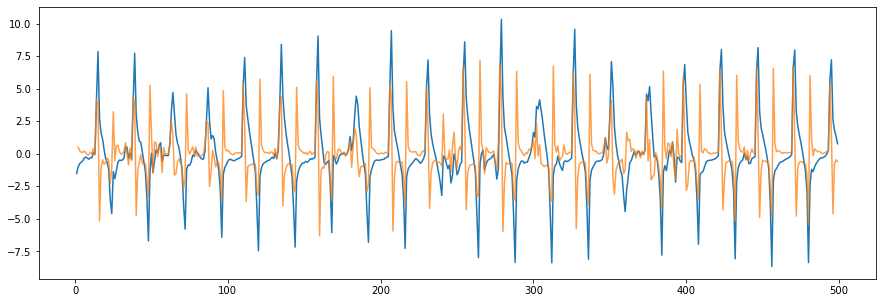

In [365]:
test['TS'].head(500).diff().plot(figsize=(15,5))
test['TS'].head(500).diff().diff().plot(figsize=(15,5), alpha=0.75)

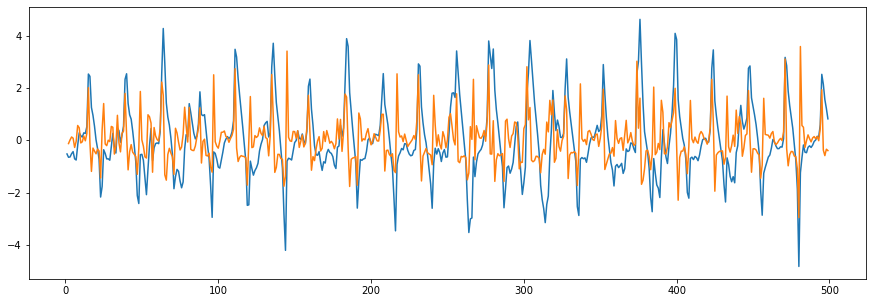

In [354]:
test['T10M'].head(500).diff().plot(figsize=(15,5))
test['T10M'].head(500).diff().diff().plot(figsize=(15,5))

## Speed

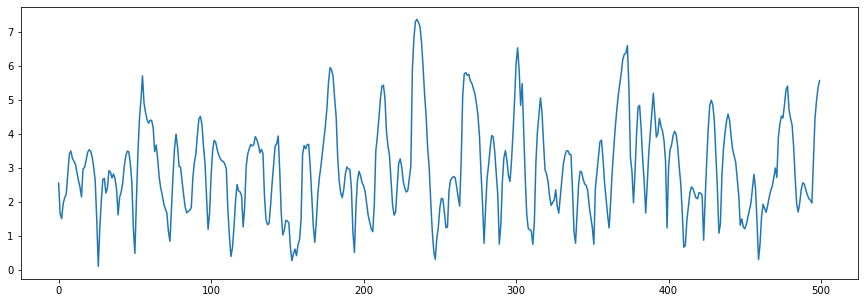

In [225]:
test['WS'].head(500).dropna().plot(figsize=(15,5))

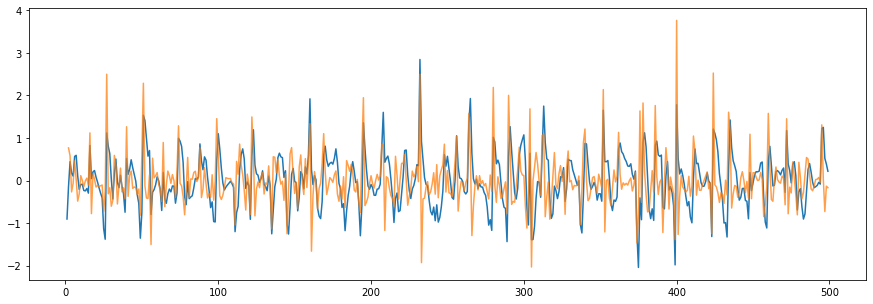

In [360]:
test['WS50M'].head(500).diff().plot(figsize=(15,5))
test['WS50M'].head(500).diff().diff().plot(figsize=(15,5), alpha=0.75)

## Direction

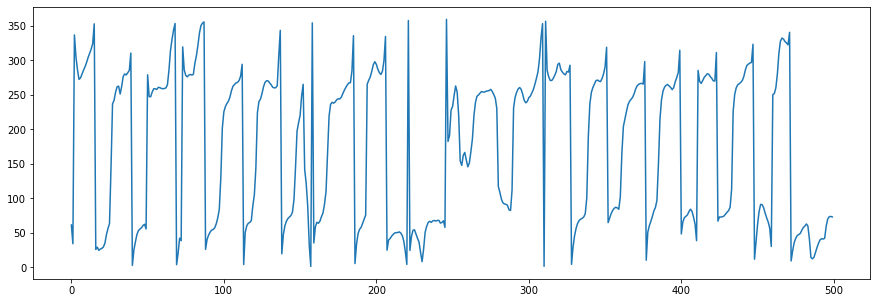

In [228]:
test['WDIR'].head(500).dropna().plot(figsize=(15,5))

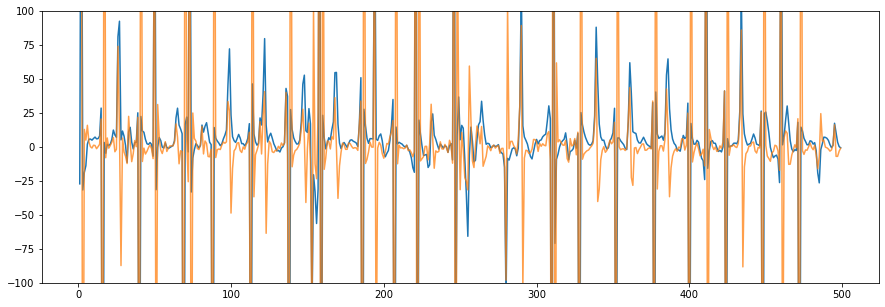

In [361]:
test['WDIR50M'].head(500).diff().plot(figsize=(15,5), ylim=(-100,100))
test['WDIR50M'].head(500).diff().diff().plot(figsize=(15,5), alpha=0.75)

## Precip

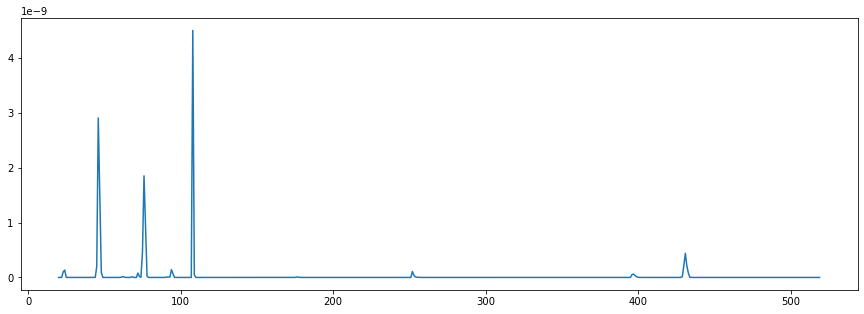

In [235]:
test['PRECTOTCORR'].iloc[20:520].dropna().plot(figsize=(15,5))

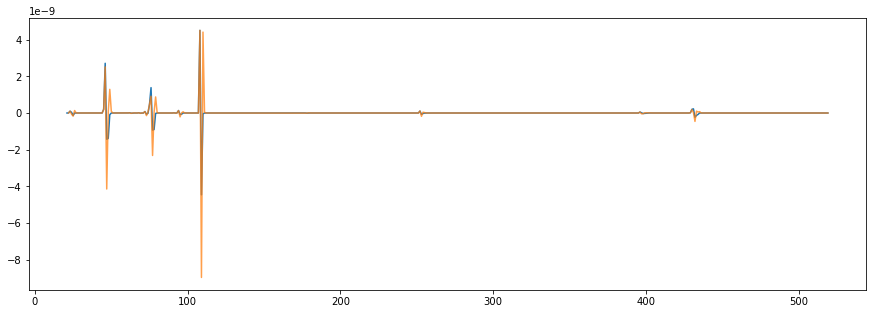

In [236]:
test['PRECTOTCORR'].iloc[20:520].diff().plot(figsize=(15,5))
test['PRECTOTCORR'].iloc[20:520].diff().diff().plot(figsize=(15,5), alpha=0.75)

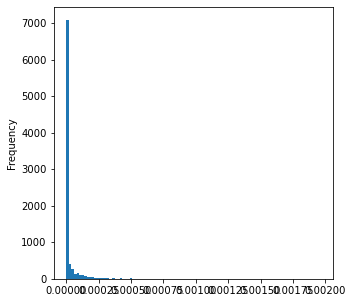

In [132]:
test['PRECTOTCORR'].head(8760).plot.hist(bins=100, logy=False, figsize=(5,5))

Per wikipedia: "Light rain — when the precipitation rate is < 2.5 mm per hour". That is the far right of this logx plot!

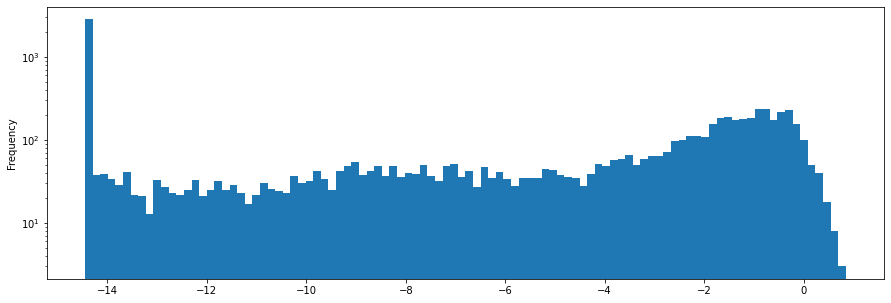

In [357]:
# *3600 to put in log10(mm/hour)
np.log10(test['PRECTOTCORR'].head(8760)*3600 + 2**-48).plot.hist(bins=100, logy=True, figsize=(15,5))

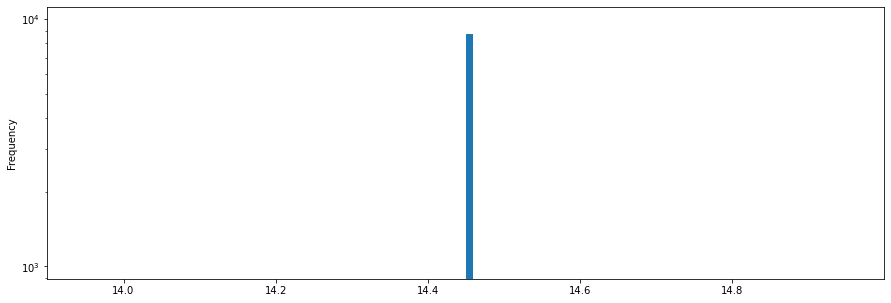

In [358]:
np.log10(test['PRECTOTCORR'].head(8760) + 2**48).plot.hist(bins=100, logy=True, figsize=(15,5))

/home/tpb/miniconda3/envs/merra/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


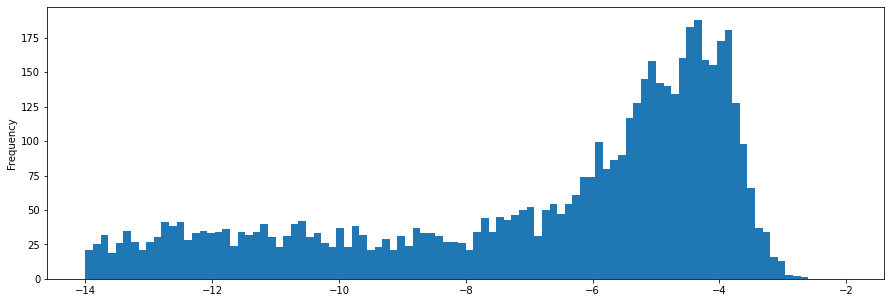

In [153]:
np.log10(test['PRECTOTCORR'].head(8760)).plot.hist(bins=100, logy=False, range=(-14, -2), figsize=(15,5))